# Variance Scanning (Variance of Distance to Center)

## Cost definition 1: (sum of variance in each dimension)

$$

\mathrm{Cost}(d, t) := \left(\frac{N_l}{N}\right)^\gamma \mathbb E \left[ (\mathbf x - \bar{\mathbf x})^2: x_d \le t \right] + \left(\frac{N_r}{N}\right)^\gamma \mathbb E \left[ (\mathbf x - \bar{\mathbf x})^2: x_d > t \right], \quad \text{where} \quad d \in \{1, 2, 3\}, \quad t \in \mathbb{R}.

$$

This cost function simply add up the variance in each dimension, which is equivalent to the mean of the squared distances to the center.

The parameter gamma is there to penalize the unbalencedness of the split. The higer the gamma, the more balanced the split will be.

However, it doens't work well in especially 3D cases such as `failure-1-torus.png`.

## Cost definition 2: (product of variance in each dimension)

$$

\mathrm{CostChild}(X) := \prod_{i=1}^3 \sqrt{\mathbb E \left[ (x_i - \bar{x}_i)^2: x \in X \right]} = \sigma_1 \sigma_2 \sigma_3  \\

\mathrm{Cost}(d, t) := \left(\frac{N_l}{N}\right)^\gamma \mathrm{CostChild}(X_l) + \left(\frac{N_r}{N}\right)^\gamma \mathrm{CostChild}(X_r)
, \quad \text{where} \quad d \in \{1, 2, 3\}, \quad t \in \mathbb{R} \\
X_l = \{ \mathbf x \in X: x_d < t \}, \quad X_r = \{ \mathbf x \in X: x_d \ge t \}.

$$

Intuition: measuring the volume of the ellipsoid that contains the data points.

Maybe: should use the determinant of the covariance matrix instead of the product of variances to account for skewness.

As seen in `failure-2-torus.png` and also the *1 uniform* case, if the data is uniformly distributed, one can prove that the optimal cost of definition 2 is proportional to $a b$, splitting at the middle point, where $a$ and $b$ are the lengths of the two axes. This might cause issues because the optimal cost is the same for all dimensions. The expected split dimension in such cases should be the one with the largest variance, whereas the algorithm will choose a random dimension due to noise.

Hence, we need to introduce a *tie-breaker* term in the cost function that is negligible when finding the split for each dimension, but is significant when comparing the costs of different dimensions. We use

$$

\mathrm{CostChild}(X) := \prod_{i=1}^D \sigma_i + \lambda \sum_{i=1}^D \sigma_i^D, \quad \text{where} \quad \lambda \ll 1.

$$

Where $D$ is the number of dimensions.

## Cost deinition 3: (covariance matrix, information gain, or entropy of the MLE Gaussian distribution fitted to the data)

$$

H(X) \propto \log \det \mathrm{Cov} \left[X \right] \\

\mathrm{Cost}(d, t) := \left(\frac{N_l}{N}\right) H(X_l) + \left(\frac{N_r}{N}\right) H(X_r)  \\

\mathrm{IG}(d, t) := H(X) - \mathrm{Cost}(d, t) \\

\min \mathrm{Cost}(d, t) = \max \mathrm{IG}(d, t)

$$

The use of full covariance matrices instead of diagonal ones can generalize the axis-aligned ellipsoids to arbitrary ones. The latter yields sub-optimal splits when the points after the split lie on a skewed plane, or when points are not really distributed like axis-aligned ellipsoids. See `failure-2d-lines-variance.png` and `failure-2d-U-variances.png` for example.

We've also tried using the volume of the ellipsoid as the metric, whose cost function is

$$

\mathrm{ChildCost}(X) := \sqrt{\det \mathrm{Cov} \left[X \right]}

$$

These two formulations both address the issue of skewed data. Information gain yields more aggressive splits, but is less robust to noise. For information gain, we've tried different gamma values, and found that 1.0 works the best, which is consistent with the information gain theory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
epsilon = 1e-90

def noisy(data, noise_std=0.01):
    return data + np.random.normal(0, noise_std, data.shape)

def sort_by_dim(data, dim):
    return data[np.argsort(data[:,dim])]

def second_min(a):
    return np.min(np.delete(a, np.argmin(a)))

def robust_det(matrix, eps):  # Robust determinant by removing degenerate eigenvalues
    return np.linalg.det(matrix)
    # eigens = np.linalg.eigvals(matrix)
    # return np.prod([eig for eig in eigens if abs(eig) > eps])

In [4]:
# Variance-based
def child_cost(data):
    return np.maximum(np.std(data, ddof=1, axis=0), epsilon).prod()

def cost_at_split(data, split, dim, gamma=1, lambd=1e-3):
    ndim = data.shape[1]
    left = data[data[:,dim] < split]
    right = data[data[:,dim] >= split]
    return (len(left)/len(data))**gamma * child_cost(left) + (len(right)/len(data))**gamma * child_cost(right) + lambd * (np.std(left, ddof=1, axis=0)**ndim).sum() + lambd * (np.std(right, ddof=1, axis=0)**ndim).sum()

def variance_scan(data, dim, gamma=1, lambd=1e-3, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    best_cost = np.inf
    best_index = None
    shape_term = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        left = data[:i]
        right = data[i:]
        cost = (i/N)**gamma * child_cost(left) + ((N-i)/N)**gamma * child_cost(right)
        if cost < best_cost:
            best_cost = cost
            best_index = i
            shape_term = (i/N)**gamma * (np.std(left, ddof=1, axis=0)**ndim).sum() + ((N-i)/N)**gamma * (np.std(right, ddof=1, axis=0)**ndim).sum()
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost + lambd * shape_term

def variance_scan_welford(data, dim, gamma=1, lambd=1e-3, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lM2 = np.var(data[:min_samples_per_side], axis=0) * min_samples_per_side
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rM2 = np.var(data[min_samples_per_side:], axis=0) * (N - min_samples_per_side)
    
    best_cost = np.inf
    best_index = None
    shape_term = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lVar = lM2 / (i - 1)
        rVar = rM2 / (N - i - 1)
        lStd = np.sqrt(np.maximum(lVar, 0))
        rStd = np.sqrt(np.maximum(rVar, 0))
        lCost = np.maximum(lStd, epsilon).prod()
        rCost = np.maximum(rStd, epsilon).prod()
        cost = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
        if cost < best_cost:
            best_cost = cost
            best_index = i
            shape_term = (i/N)**gamma * (lStd**ndim).sum() + ((N-i)/N)**gamma * (rStd**ndim).sum()
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lM2 += delta * delta2
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rM2 -= delta * delta2
    
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost + lambd * shape_term

def variance_scan_all(data, gamma=1, lambd=1e-3, min_samples_per_side=2):
    ndim = data.shape[1]
    splits = np.zeros(ndim)
    costs = np.zeros(ndim)
    for dim in range(ndim):
        splits[dim], costs[dim] = variance_scan_welford(data, dim, gamma, lambd, min_samples_per_side)
        # splits[dim], costs[dim] = variance_scan(data, dim, gamma, lambd, min_samples_per_side)
    return splits, costs

def cost_curve(data, dim, gamma=1, lambd=1e-3, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    costs = np.zeros((N,))
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lM2 = np.var(data[:min_samples_per_side], axis=0) * min_samples_per_side
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rM2 = np.var(data[min_samples_per_side:], axis=0) * (N - min_samples_per_side)
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lVar = lM2 / (i - 1)
        rVar = rM2 / (N - i - 1)
        lStd = np.sqrt(np.maximum(lVar, 0))
        rStd = np.sqrt(np.maximum(rVar, 0))
        lCost = np.maximum(lStd, epsilon).prod() + lambd * (lStd**ndim).sum()
        rCost = np.maximum(rStd, epsilon).prod() + lambd * (rStd**ndim).sum()
        costs[i] = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lM2 += delta * delta2
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rM2 -= delta * delta2
    
    splits = (data[min_samples_per_side - 1: N - min_samples_per_side, dim] + data[min_samples_per_side: N - min_samples_per_side + 1, dim]) / 2
    return splits, costs[min_samples_per_side: N - min_samples_per_side + 1]

def cost_curve_all(data, gamma=1, lambd=1e-3, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    split_curves = np.zeros((ndim, N - 2*min_samples_per_side + 1))
    cost_curves = np.zeros_like(split_curves)
    for dim in range(ndim):
        split_curves[dim], cost_curves[dim] = cost_curve(data, dim, gamma, lambd, min_samples_per_side)
    return split_curves, cost_curves

In [14]:
# Covariance-based
def child_cost(data):
    cov = np.cov(data, rowvar=False, ddof=1)
    # return np.sqrt(np.maximum(np.linalg.det(cov), 0))   # volume of the skewed ellipsoid
    return np.log(np.maximum(robust_det(cov, 1e-3), epsilon))   # entropy of the MLE Gaussian

def cost_at_split(data, split, dim, gamma=1):
    left = data[data[:,dim] < split]
    right = data[data[:,dim] >= split]
    return (len(left)/len(data))**gamma * child_cost(left) + (len(right)/len(data))**gamma * child_cost(right)

def variance_scan(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    best_cost = np.inf
    best_index = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        cost = (i/N)**gamma * child_cost(data[:i]) + ((N-i)/N)**gamma * child_cost(data[i:])
        if cost < best_cost:
            best_cost = cost
            best_index = i
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost

def variance_scan_welford(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lC = np.cov(data[:min_samples_per_side], rowvar=False, ddof=0) * min_samples_per_side  # comoment matrix
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rC = np.cov(data[min_samples_per_side:], rowvar=False, ddof=0) * (N - min_samples_per_side)
    
    best_cost = np.inf
    best_index = None
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lCov = lC / (i-1)
        rCov = rC / (N-i-1)
        
        # lCost = np.sqrt(np.maximum(np.linalg.det(lCov), 0))
        # rCost = np.sqrt(np.maximum(np.linalg.det(rCov), 0))
        lCost = np.log(np.maximum(robust_det(lCov, 1e-3), epsilon))
        rCost = np.log(np.maximum(robust_det(rCov, 1e-3), epsilon))
        cost = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
        if cost < best_cost:
            best_cost = cost
            best_index = i
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lC += np.outer(delta, delta2)
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rC -= np.outer(delta, delta2)
    
    assert best_index is not None
    best_split = (data[best_index,dim] + data[best_index-1,dim]) / 2
    return best_split, best_cost

def variance_scan_all(data, gamma=1, min_samples_per_side=2):
    ndim = data.shape[1]
    splits = np.zeros(ndim)
    costs = np.zeros(ndim)
    for dim in range(ndim):
        splits[dim], costs[dim] = variance_scan_welford(data, dim, gamma, min_samples_per_side)
        # splits[dim], costs[dim] = variance_scan(data, dim, gamma, min_samples_per_side)
    return splits, costs

def cost_curve(data, dim, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    assert dim < ndim
    data = sort_by_dim(data, dim)
    costs = np.zeros((N,))
    # Welford's online algorithm for variance
    lMean = np.mean(data[:min_samples_per_side], axis=0)
    lC = np.cov(data[:min_samples_per_side], rowvar=False, ddof=0) * min_samples_per_side  # comoment matrix
    rMean = np.mean(data[min_samples_per_side:], axis=0)
    rC = np.cov(data[min_samples_per_side:], rowvar=False, ddof=0) * (N - min_samples_per_side)
    for i in range(min_samples_per_side, N - min_samples_per_side + 1):
        x = data[i]
        lCov = lC / (i-1)
        rCov = rC / (N-i-1)
        
        # lCost = np.sqrt(np.maximum(np.linalg.det(lCov), 0))
        # rCost = np.sqrt(np.maximum(np.linalg.det(rCov), 0))
        lCost = np.log(np.maximum(robust_det(lCov, 1e-3), epsilon))
        rCost = np.log(np.maximum(robust_det(rCov, 1e-3), epsilon))
        costs[i] = (i/N)**gamma * lCost + ((N-i)/N)**gamma * rCost
            
        # Update statistics
        delta = x - lMean
        lMean += delta / (i+1)
        delta2 = x - lMean
        lC += np.outer(delta, delta2)
        
        delta2 = x - rMean
        rMean = ((N-i) * rMean - x) / (N-i-1)
        delta = x - rMean
        rC -= np.outer(delta, delta2)
    
    splits = (data[min_samples_per_side - 1: N - min_samples_per_side, dim] + data[min_samples_per_side: N - min_samples_per_side + 1, dim]) / 2
    return splits, costs[min_samples_per_side: N - min_samples_per_side + 1]

def cost_curve_all(data, gamma=1, min_samples_per_side=2):
    N, ndim = data.shape
    assert N >= 2*min_samples_per_side
    split_curves = np.zeros((ndim, N - 2*min_samples_per_side + 1))
    cost_curves = np.zeros_like(split_curves)
    for dim in range(ndim):
        split_curves[dim], cost_curves[dim] = cost_curve(data, dim, gamma, min_samples_per_side)
    return split_curves, cost_curves

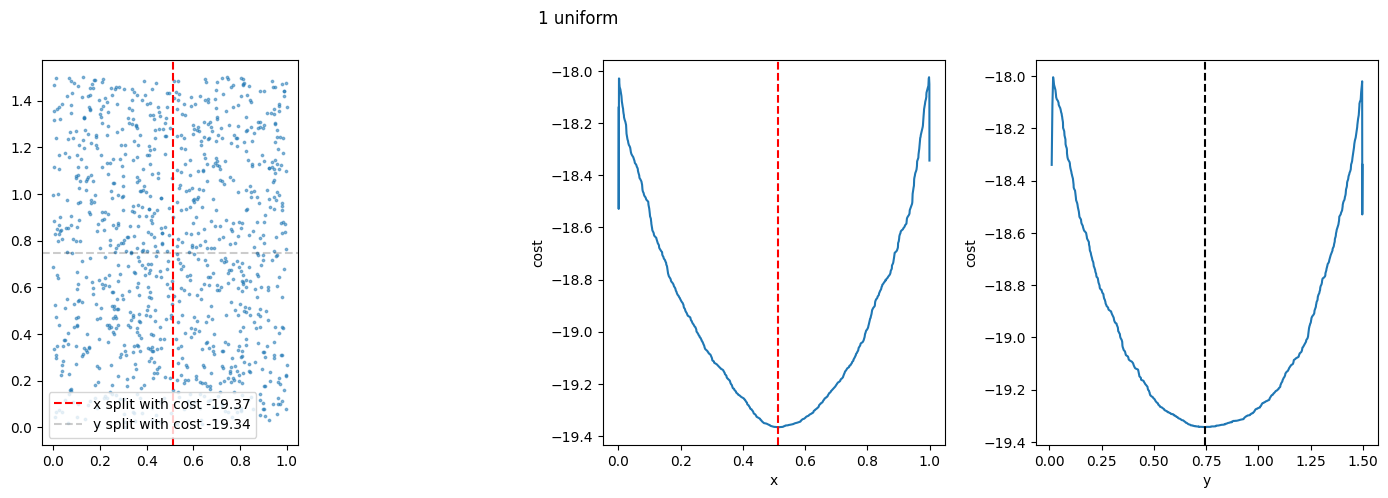

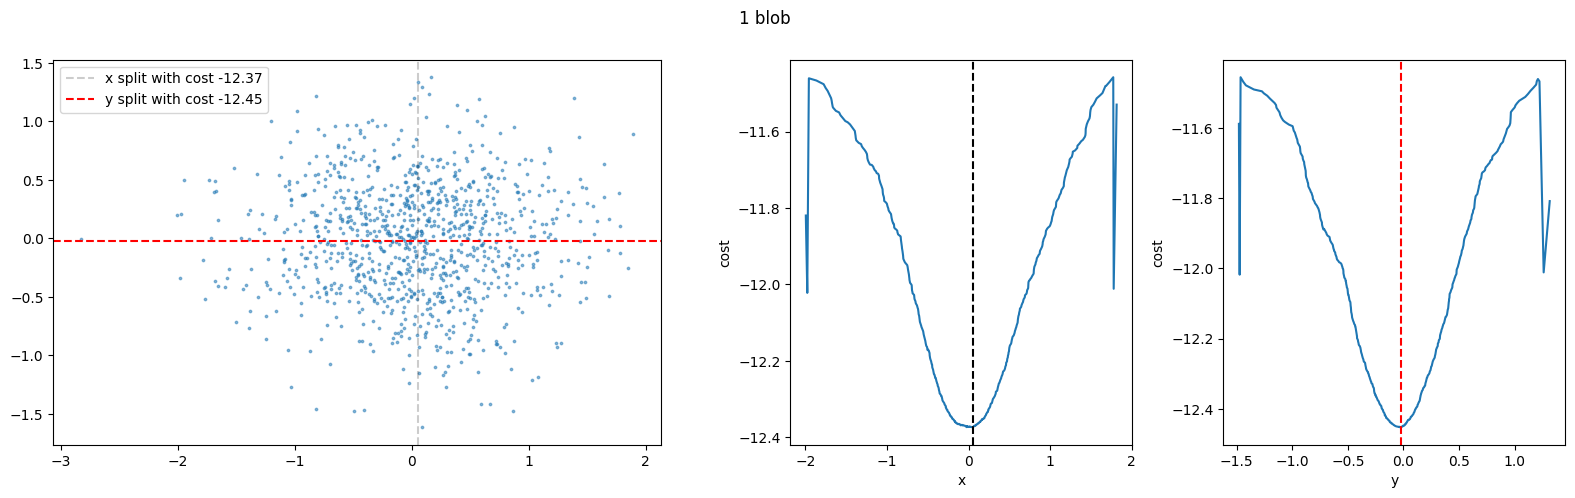

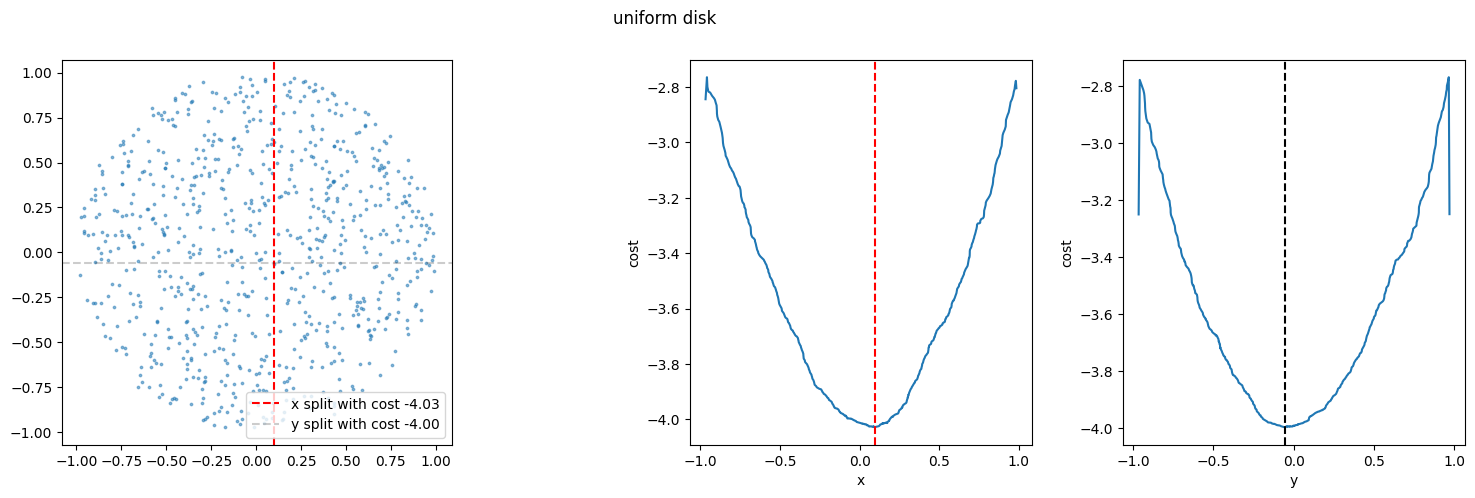

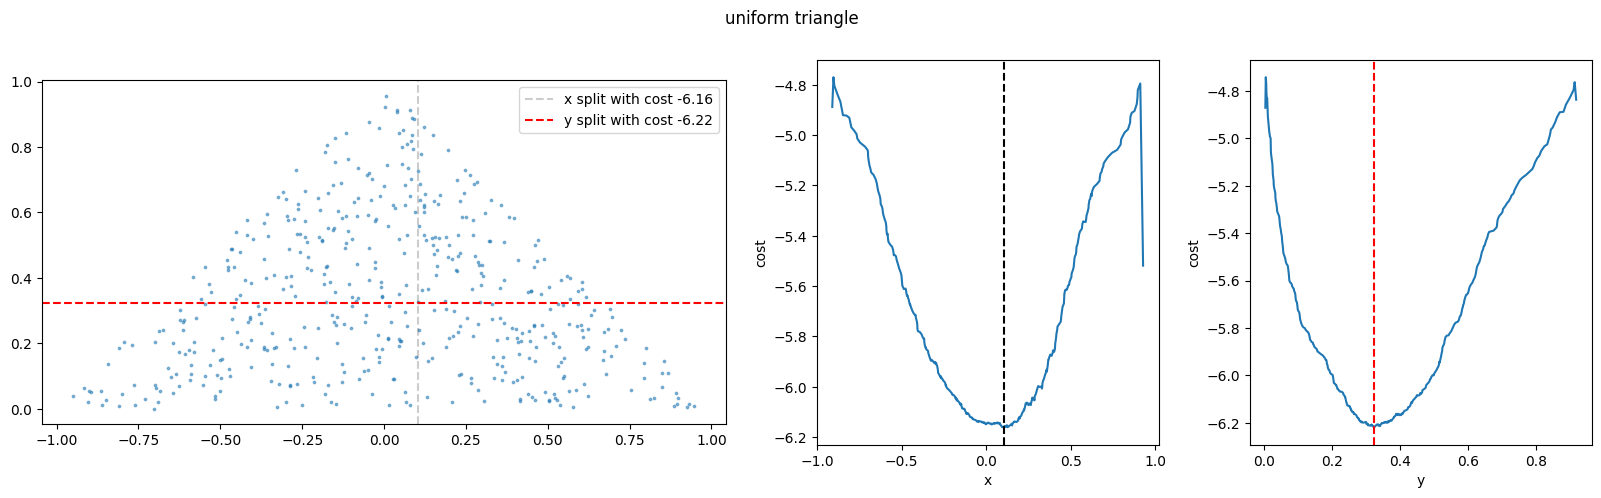

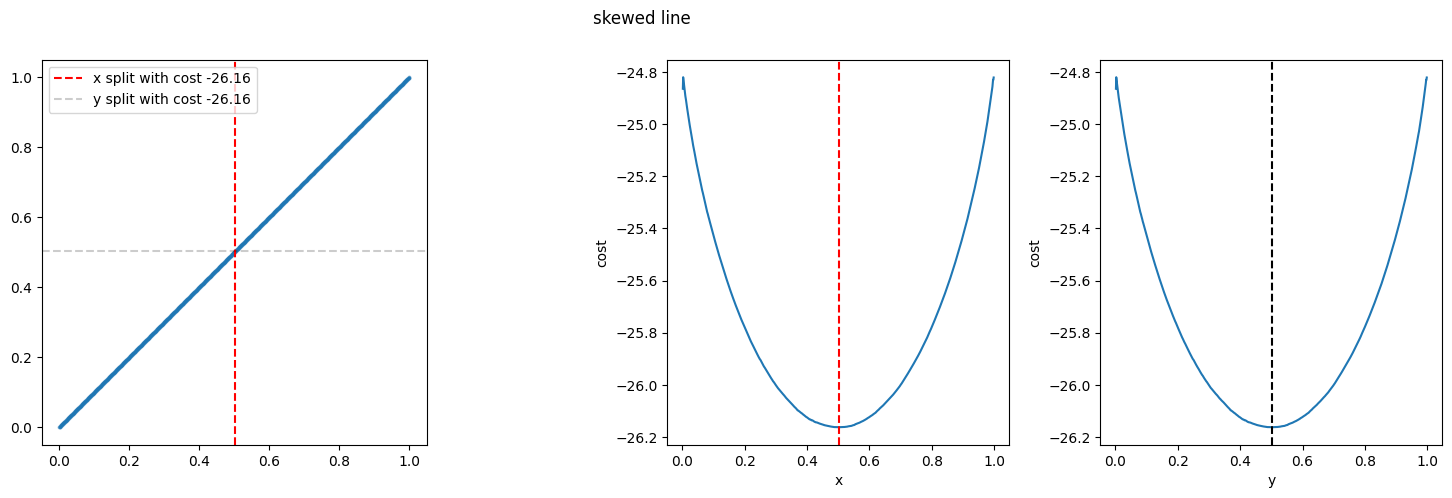

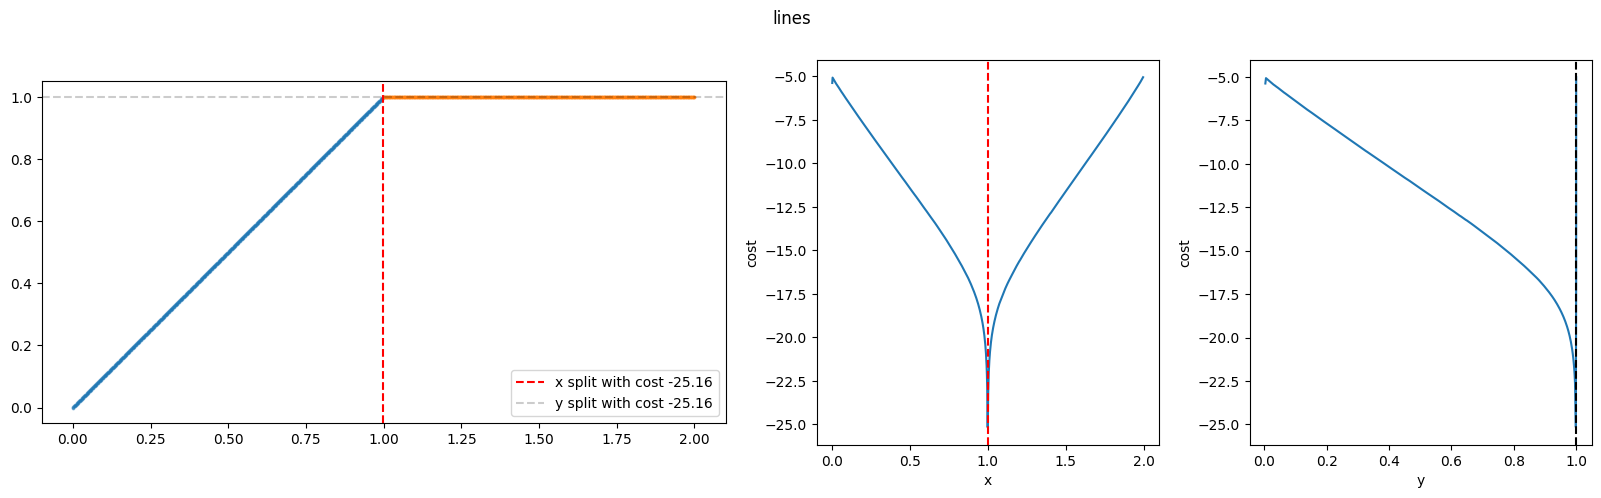

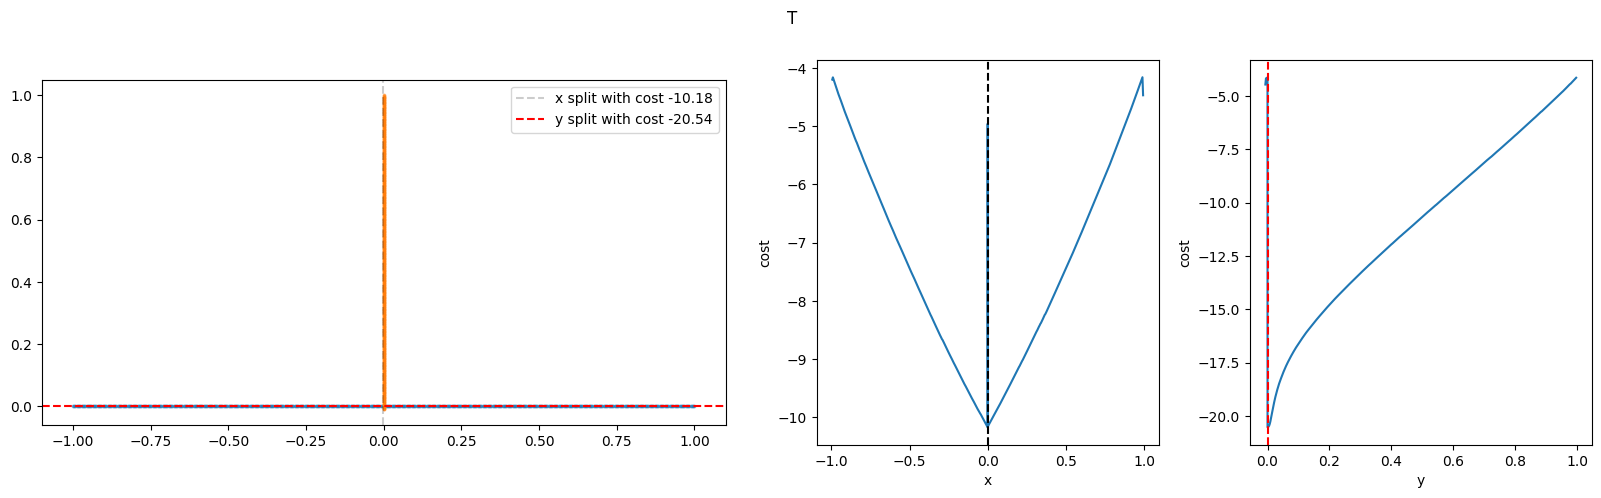

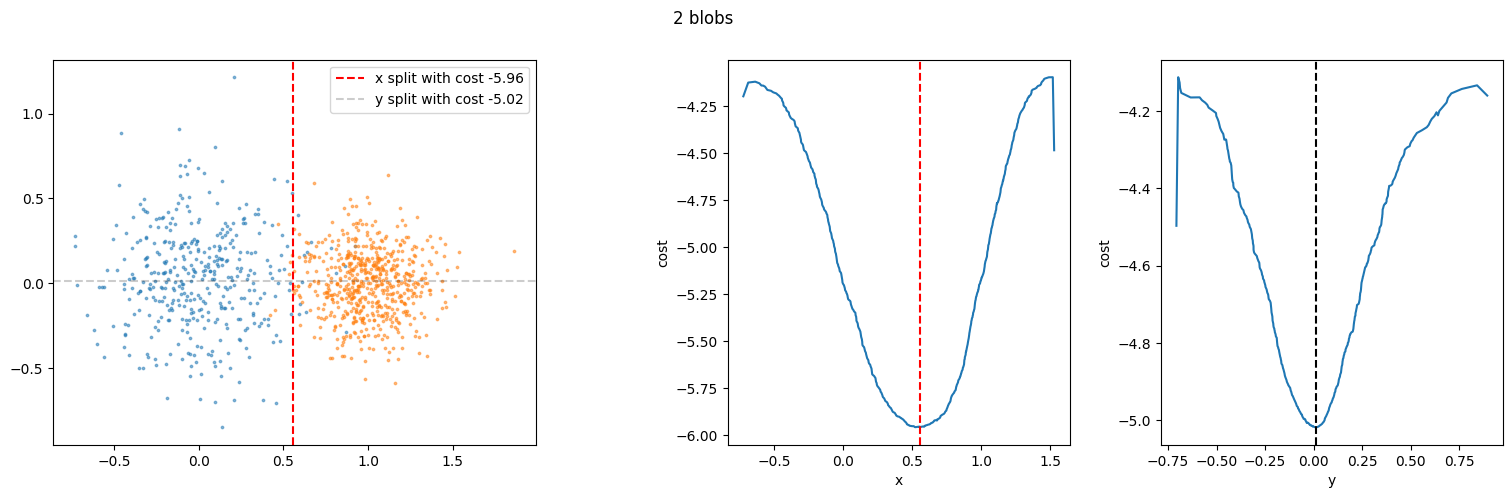

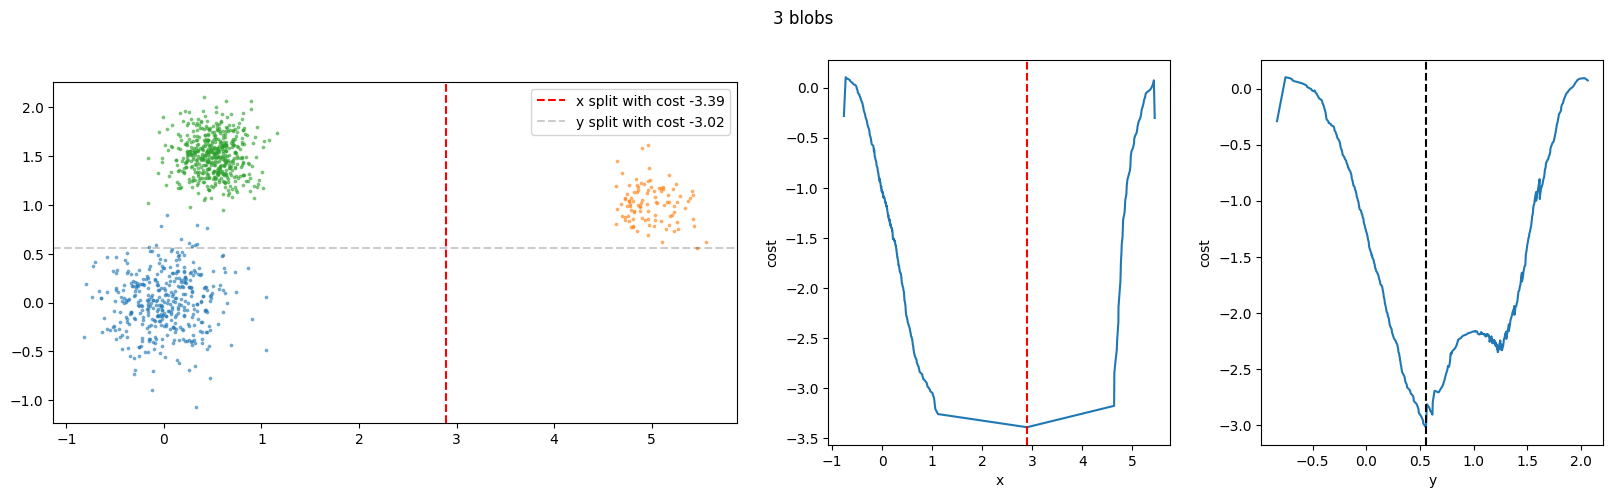

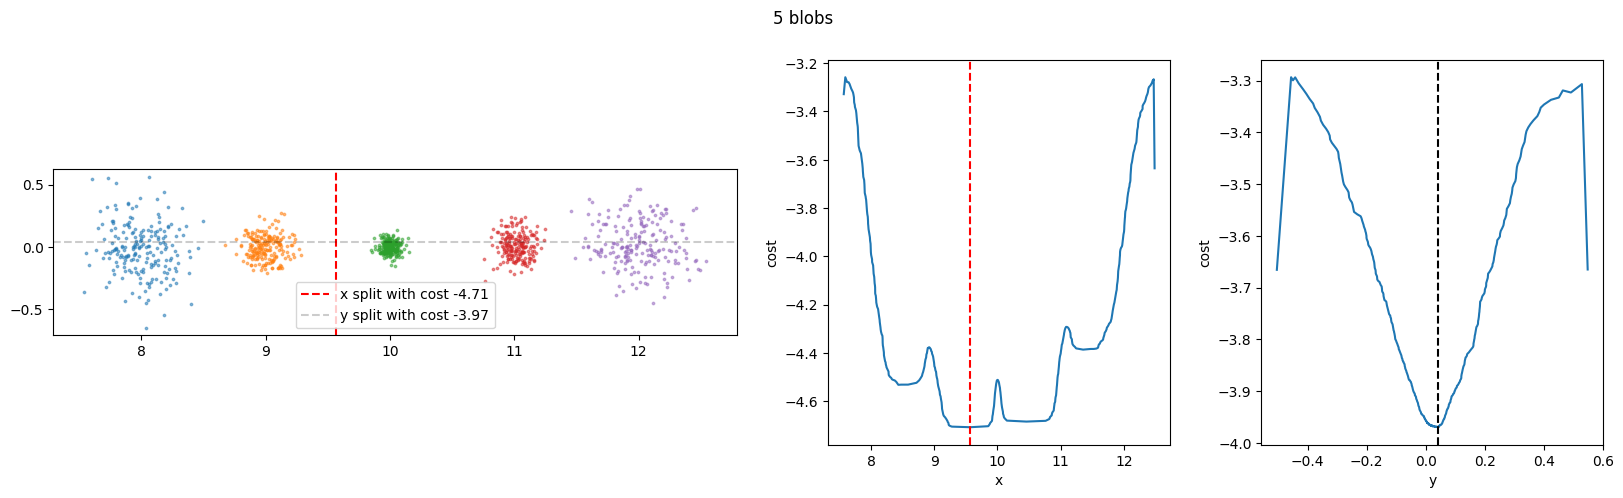

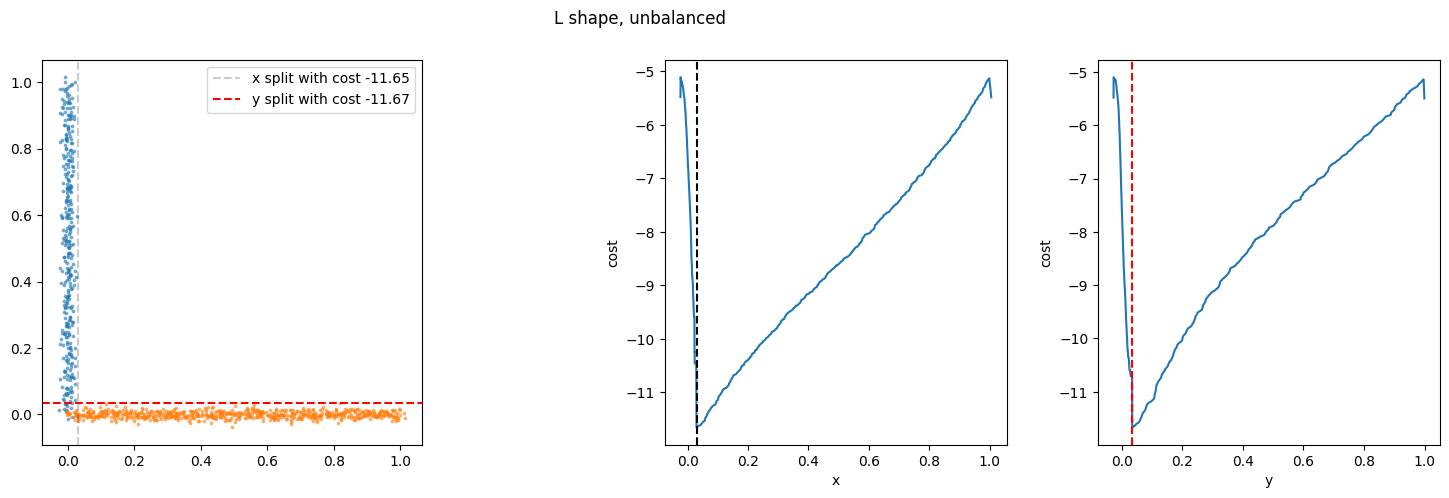

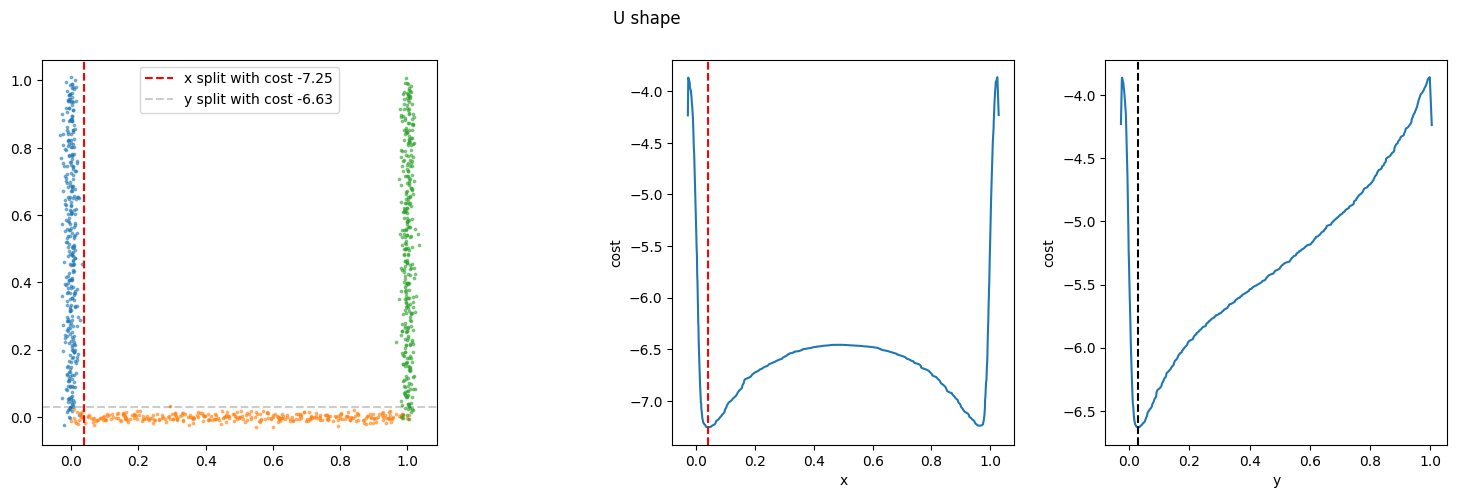

In [15]:
# 2D experiments
def uniform_disk(num_samples):
    X = np.random.uniform(-1, 1, (num_samples, 2))
    X = X[np.linalg.norm(X, axis=1) < 1]
    return X

def uniform_triangle(num_samples):
    X = np.random.uniform((-1, 0), (1, 1), (num_samples, 2))
    X = X[np.abs(X[:,0]) + np.abs(X[:,1]) < 1]
    return X

k = 0.2
num_samples = 1000
# np.random.seed(43)
dataset = [
    ('1 uniform', [
        noisy(np.random.uniform((0, 0, 0), (1, 1.5, 0), size=(num_samples, 3)), noise_std=1e-3),
    ]),
    ('1 blob', [
        np.random.normal((0, 0, 0), (0.7, 0.5, 0.01), size=(num_samples, 3)),
    ]),
    ('uniform disk', [
        uniform_disk(num_samples),
    ]),
    ('uniform triangle', [
        uniform_triangle(num_samples),
    ]),
    ('skewed line', [
        # noisy(np.linspace((0, 0), (1, 1), num_samples), 1e-8),
        np.linspace((0, 0), (1, 1), num_samples),
    ]),
    ('lines', [
        np.linspace((0, 0), (1, 1), num_samples // 2),
        np.linspace((1, 1), (2, 1), num_samples // 2),
    ]),
    ('T', [
        np.linspace((-1, 0), (1, 0), num_samples // 2),
        np.linspace((0, -0.01), (0, 1), num_samples // 2),
    ]),
    ('2 blobs', [
        np.random.normal((0, 0), (0.3, 0.3), size=(num_samples * 4 // 10, 2)),
        np.random.normal((1, 0), (0.2, 0.2), size=(num_samples * 6 // 10, 2)),
    ]),
    ('3 blobs', [
        np.random.normal((0, 0), (0.3, 0.3), size=(num_samples * 4 // 10, 2)),
        np.random.normal((5, 1), (0.2, 0.2), size=(num_samples * 1 // 10, 2)),
        np.random.normal((0.5, 1.5), (0.2, 0.2), size=(num_samples * 5 // 10, 2)),
    ]),
    ('5 blobs', [
        np.random.normal((10-2, 0), (0.2, 0.2), size=(num_samples // 5, 2)),
        np.random.normal((10-1, 0), (0.1, 0.1), size=(num_samples // 5, 2)),
        np.random.normal((10+0, 0), (0.05, 0.05), size=(num_samples // 5, 2)),
        np.random.normal((10+1, 0), (0.1, 0.1), size=(num_samples // 5, 2)),
        np.random.normal((10+2, 0), (0.2, 0.2), size=(num_samples // 5, 2)),
    ]),
    # ('L shape', [
    #     noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 2)),
    #     noisy(np.linspace((0, 0), (1, 0), num_samples * 1 // 2)),
    # ]),
    ('L shape, unbalanced', [
        noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 3)),
        noisy(np.linspace((0, 0), (1, 0), num_samples * 2 // 3)),
    ]),
    ('U shape', [
        noisy(np.linspace((0, 0), (0, 1), num_samples * 1 // 3)),
        noisy(np.linspace((0, 0), (1, 0), num_samples * 1 // 3)),
        noisy(np.linspace((1, 0), (1, 1), num_samples * 1 // 3)),
    ])
]

kwargs = {
    'gamma': 1,
    'min_samples_per_side': 2,
}

for name, groups in dataset:
    X = np.concatenate(groups)
    X = noisy(X, 1e-5)
    entropy = np.log(np.maximum(robust_det(np.cov(X, rowvar=False, ddof=1), 1e-3), epsilon))
    # print("Entropy:", entropy)

    split_curves, cost_curves = cost_curve_all(X, **kwargs)
    costs = cost_curves.min(axis=1)[:2]
    splits = np.array([split_curves[i, cost_curves[i].argmin()] for i in range(2)])[:2]
    # splits, costs = variance_scan_all(X, **kwargs)
    min_cost = min(costs)
    second_min_cost = second_min(costs)
    if min_cost < k * second_min_cost:
        best_dim = np.argmin(costs)  # use the argmin if the best cost is significantly lower than the second best
    else:
        best_dim = np.argmax(np.var(X, axis=0, ddof=1))  # use the dimension with the highest variance otherwise

    fig, (axSamples, axCurveX, axCurveY) = plt.subplots(1, 3, figsize=(20, 5), width_ratios=[2, 1, 1])
    for group in groups:
        axSamples.scatter(group[:, 0], group[:, 1], alpha=0.5, s=3)
    dim_colors = ['k', 'k']
    dim_colors[best_dim] = 'r'
    axSamples.axvline(splits[0], color=dim_colors[0], linestyle='--', label=f'x split with cost {costs[0]:.2f}', alpha=1 if best_dim == 0 else 0.2)
    axSamples.axhline(splits[1], color=dim_colors[1], linestyle='--', label=f'y split with cost {costs[1]:.2f}', alpha=1 if best_dim == 1 else 0.2)
    axSamples.set_aspect(1)
    axSamples.legend()
    
    axCurveX.plot(split_curves[0], cost_curves[0], label='x')
    axCurveX.axvline(splits[0], color=dim_colors[0], linestyle='--')
    # axCurveX.axhline(entropy, color='blue', linestyle='--', alpha=0.5)
    axCurveX.set_xlabel('x')
    axCurveX.set_ylabel('cost')
    axCurveX.set_aspect('auto')
    axCurveY.plot(split_curves[1], cost_curves[1], label='y')
    axCurveY.axvline(splits[1], color=dim_colors[1], linestyle='--')
    # axCurveY.axhline(entropy, color='blue', linestyle='--', alpha=0.5)
    axCurveY.set_xlabel('y')
    axCurveY.set_ylabel('cost')
    axCurveY.set_aspect('auto')
    
    fig.suptitle(name)
    plt.show()

In [7]:
# Load 3D sample data from disk
def load_samples(sample_dir, iteration, max_num_samples=10000):
    position = np.load(f"{sample_dir}/position-{iteration}.npy")
    direction = np.load(f"{sample_dir}/direction-{iteration}.npy")
    weight = np.load(f"{sample_dir}/weight-{iteration}.npy")
    assert position.shape[0] == direction.shape[0] == weight.shape[0]
    print(f"Loaded {position.shape[0]} samples")
    num_samples = min(max_num_samples, position.shape[0])
    selected_indices = np.random.choice(position.shape[0], num_samples, replace=False)
    position = position[selected_indices]
    direction = direction[selected_indices]
    weight = weight[selected_indices]
    print(f"Using {num_samples} samples")
    return position, direction, weight

position, direction, weight = load_samples("data/cbox-empty-samples-vs3d", 2, 10000)
# sample_dir = "data/pbrt-book"
# position = np.load(f"{sample_dir}/position-2.npy")
# selected_indices = np.random.choice(position.shape[0], 10000, replace=False)
# position = position[selected_indices]
# weight = np.ones((position.shape[0],))
roi = np.array([
    [-0.99, 0],
    [0.81, 1.999],
    [-1.1, -0.9],
])
# roi = np.stack([position.min(axis=0), position.max(axis=0)], axis=1)

Loaded 204325 samples
Using 10000 samples


In [9]:
%matplotlib widget
from ipywidgets import AppLayout, FloatSlider, VBox, HBox

plt.close('all')
plt.ioff()

bounds = np.stack([position.min(axis=0), position.max(axis=0)], axis=1) # 3x2
# extent = bounds[:, 1] - bounds[:, 0]
# bounds += np.array([-0.1, 0.1])[None, :] * extent[:, None]
if roi is None:
    roi = np.array([[-8.64396667,  8.14603333],
        [-2.69104407,  1.94895593],
        [-8.61017197,  8.60982803]])
slider_xmin = FloatSlider(orientation='horizontal', value=roi[0, 0], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmin:')
slider_xmax = FloatSlider(orientation='horizontal', value=roi[0, 1], min=bounds[0, 0], max=bounds[0, 1], step=0.01, description='xmax:')
slider_ymin = FloatSlider(orientation='horizontal', value=roi[1, 0], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymin:')
slider_ymax = FloatSlider(orientation='horizontal', value=roi[1, 1], min=bounds[1, 0], max=bounds[1, 1], step=0.01, description='ymax:')
slider_zmin = FloatSlider(orientation='horizontal', value=roi[2, 0], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmin:')
slider_zmax = FloatSlider(orientation='horizontal', value=roi[2, 1], min=bounds[2, 0], max=bounds[2, 1], step=0.01, description='zmax:')

fig, (ax, axXOY, axZOY) = plt.subplots(1, 3, figsize=(13, 5))
ax.scatter(position[:, 0], position[:, 2], c=weight, s=2, alpha=0.2)
focusXOZ = ax.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]], 'r--')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_aspect('equal')
axXOY.scatter(position[:, 0], position[:, 1], c=weight, s=2, alpha=0.2)
focusXOY = axXOY.plot([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axXOY.set_xlabel('x')
axXOY.set_ylabel('y')
axXOY.set_aspect('equal')
axZOY.scatter(position[:, 2], position[:, 1], c=weight, s=2, alpha=0.2)
focusZOY = axZOY.plot([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]], [roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]], 'r--')
axZOY.set_xlabel('z')
axZOY.set_ylabel('y')
axZOY.set_aspect('equal')
plt.tight_layout()

def make_callback(i, j):
    def update_focus(change):
        roi[i, j] = change.new
        focusXOZ[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOZ[0].set_ydata([roi[2, 0], roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0]])
        focusXOY[0].set_xdata([roi[0, 0], roi[0, 1], roi[0, 1], roi[0, 0], roi[0, 0]])
        focusXOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        focusZOY[0].set_xdata([roi[2, 0], roi[2, 1], roi[2, 1], roi[2, 0], roi[2, 0]])
        focusZOY[0].set_ydata([roi[1, 0], roi[1, 0], roi[1, 1], roi[1, 1], roi[1, 0]])
        fig.canvas.draw()
        # fig.canvas.flush_events()
    return update_focus

slider_xmin.observe(make_callback(0, 0), names='value')
slider_xmax.observe(make_callback(0, 1), names='value')
slider_ymin.observe(make_callback(1, 0), names='value')
slider_ymax.observe(make_callback(1, 1), names='value')
slider_zmin.observe(make_callback(2, 0), names='value')
slider_zmax.observe(make_callback(2, 1), names='value')

for slider in [slider_xmin, slider_xmax, slider_ymin, slider_ymax, slider_zmin, slider_zmax]:
    slider.layout.width = '40%'

AppLayout(
    center=fig.canvas,
    footer=VBox([HBox([slider_xmin, slider_xmax]), HBox([slider_ymin, slider_ymax]), HBox([slider_zmin, slider_zmax])]),
)

AppLayout(children=(VBox(children=(HBox(children=(FloatSlider(value=-8.643966674804688, description='xmin:', l…

Current focus:
[[-8.64747452  8.14252548]
 [-2.69104407  1.95177761]
 [-8.61371887  8.60628113]]
Number of samples in focus: 997
Splits: [-3.87934957 -1.29808231 -2.66289026]
Costs: [7.40923578 5.81406323 9.22265497]
Best split dimension: 1


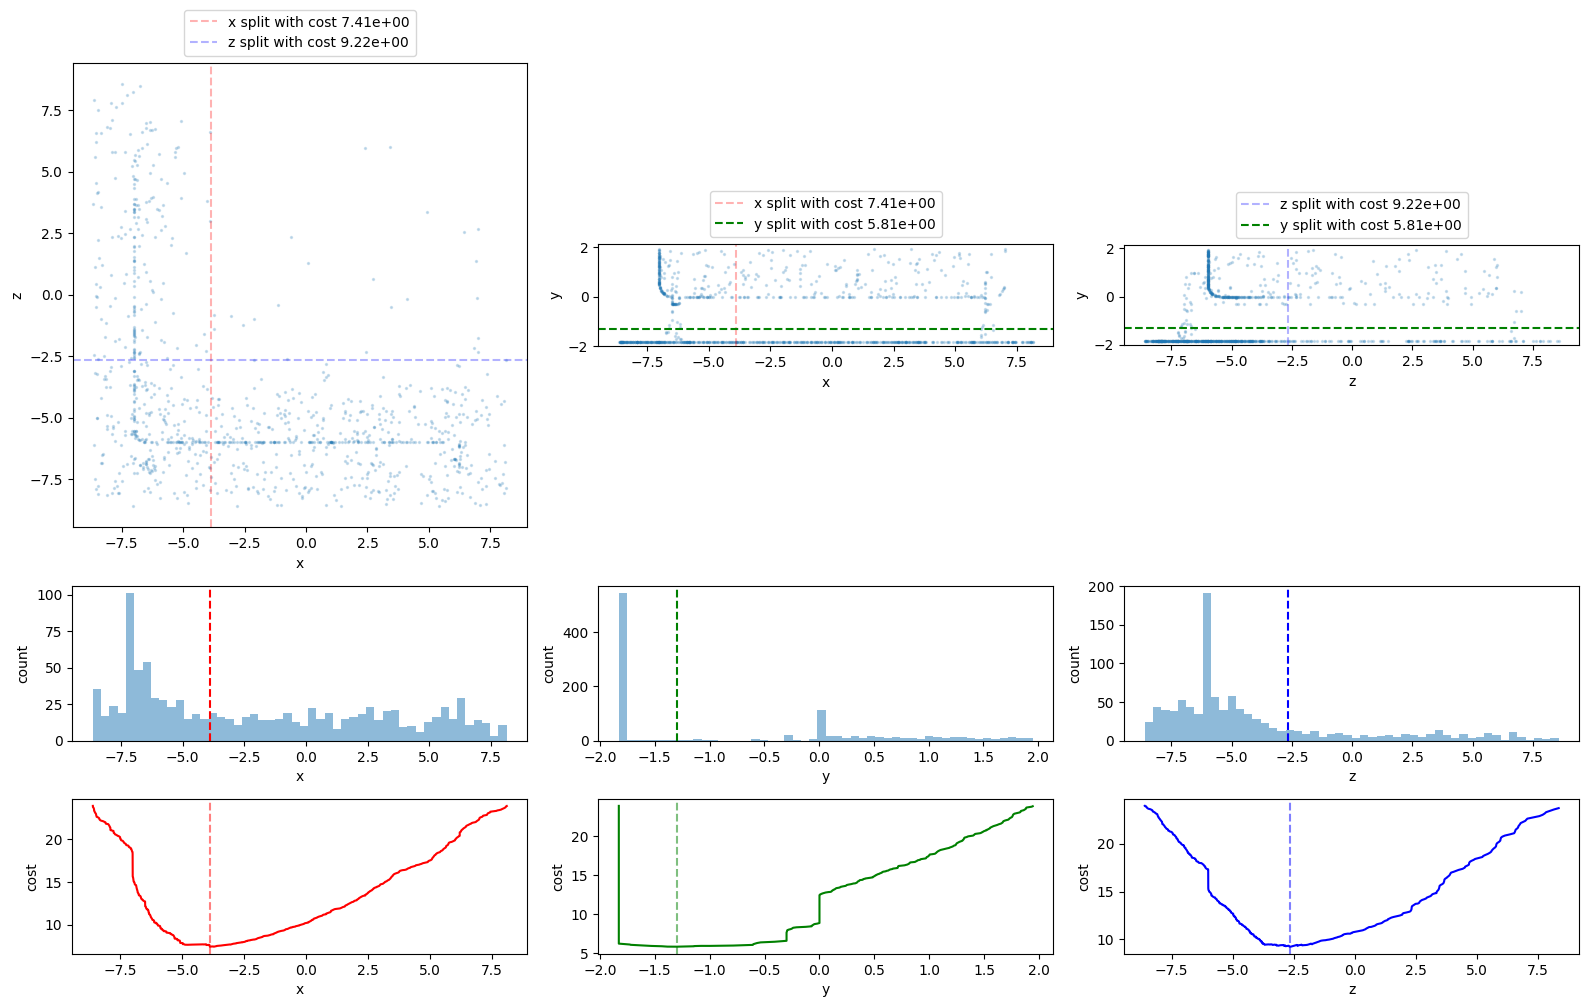

In [10]:
# Plot the focused samples, split locations, cost curves, and histograms
def visualize3D(position, roi, reduction_threshold=0.2, **kwargs):
    print("Current focus:")
    print(roi)

    mask = (position[:, 0] >= roi[0, 0]) & (position[:, 0] <= roi[0, 1]) & (position[:, 1] >= roi[1, 0]) & (position[:, 1] <= roi[1, 1]) & (position[:, 2] >= roi[2, 0]) & (position[:, 2] <= roi[2, 1])
    X = position[mask]
    print(f"Number of samples in focus: {X.shape[0]}")
    X = noisy(X, 1e-6)
    entropy = np.log(np.maximum(robust_det(np.cov(X, rowvar=False, ddof=1), 1e-3), epsilon))
    split_curves, cost_curves = cost_curve_all(X, **kwargs)
    costs = cost_curves.min(axis=1)
    splits = np.array([split_curves[i, cost_curves[i].argmin()] for i in range(3)])
    # splits, costs = variance_scan_all(X, **kwargs)
    min_cost = min(costs)
    second_min_cost = second_min(costs)
    if (second_min_cost - min_cost) / second_min_cost > reduction_threshold:
        best_dim = np.argmin(costs)  # use the argmin if the best cost is significantly lower than the second best
    else:
        # The higher the reduction_threshold, the more isotropic the split will be
        print("The min cost is too close to the second min cost, using the dimension with the highest variance instead.")
        best_dim = np.argmax(np.var(X, axis=0, ddof=1))
    print("Splits:", splits)
    print("Costs:", costs)
    print(f"Best split dimension: {best_dim}")

    fig, axes = plt.subplots(3, 3, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1, 1]})
    (axesSample, axesHist, axesCurve) = axes
    for ax, (hdim, vdim) in zip(axesSample, [(0, 2), (0, 1), (2, 1)]):
        hcolor = ['r', 'g', 'b'][hdim]
        vcolor = ['r', 'g', 'b'][vdim]
        hname = ['x', 'y', 'z'][hdim]
        vname = ['x', 'y', 'z'][vdim]
        ax.scatter(X[:, hdim], X[:, vdim], s=2, alpha=0.2)
        ax.axvline(splits[hdim], color=hcolor, linestyle='--', label=f'{hname} split with cost {costs[hdim]:.2e}', alpha=1.0 if hdim == best_dim else 0.3)
        ax.axhline(splits[vdim], color=vcolor, linestyle='--', label=f'{vname} split with cost {costs[vdim]:.2e}', alpha=1.0 if vdim == best_dim else 0.3)
        ax.set_xlabel(hname)
        ax.set_ylabel(vname)
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0))
        ax.set_aspect('equal')

    for dim, ax in enumerate(axesHist):
        ax.hist(X[:, dim], bins=50, alpha=0.5)
        split = splits[dim]
        dim_name = ['x', 'y', 'z'][dim]
        color = ['r', 'g', 'b'][dim]
        ax.axvline(split, color=color, linestyle='--')
        ax.set_xlabel(dim_name)
        ax.set_ylabel("count")
        ax.set_aspect('auto')
        
    for dim, ax in enumerate(axesCurve):
        split = splits[dim]
        dim_name = ['x', 'y', 'z'][dim]
        color = ['r', 'g', 'b'][dim]
        ax.plot(split_curves[dim], cost_curves[dim], color=color)
        ax.axvline(split, color=color, linestyle='--', alpha=0.5)
        # ax.axhline(entropy, color='gray', linestyle='--', alpha=0.5)
        ax.set_xlabel(dim_name)
        ax.set_ylabel("cost")
        ax.set_aspect('auto')

    plt.tight_layout()
    plt.show()
    
plt.close('all')
%matplotlib inline

# visualize3D(position, roi, gamma=1, lambd=1e-2)
visualize3D(position, roi, gamma=1, min_samples_per_side=2)

Loaded 687278 samples
Using 10000 samples
Current focus:
[[-8.64396667  8.14603333]
 [-2.69104407  1.94895593]
 [-8.61017197  8.60982803]]
Number of samples in focus: 995
Splits: [-3.8793481  -1.29808231 -2.66288913]
Costs: [7.30078897 5.76297606 9.10882848]
Best split dimension: 1


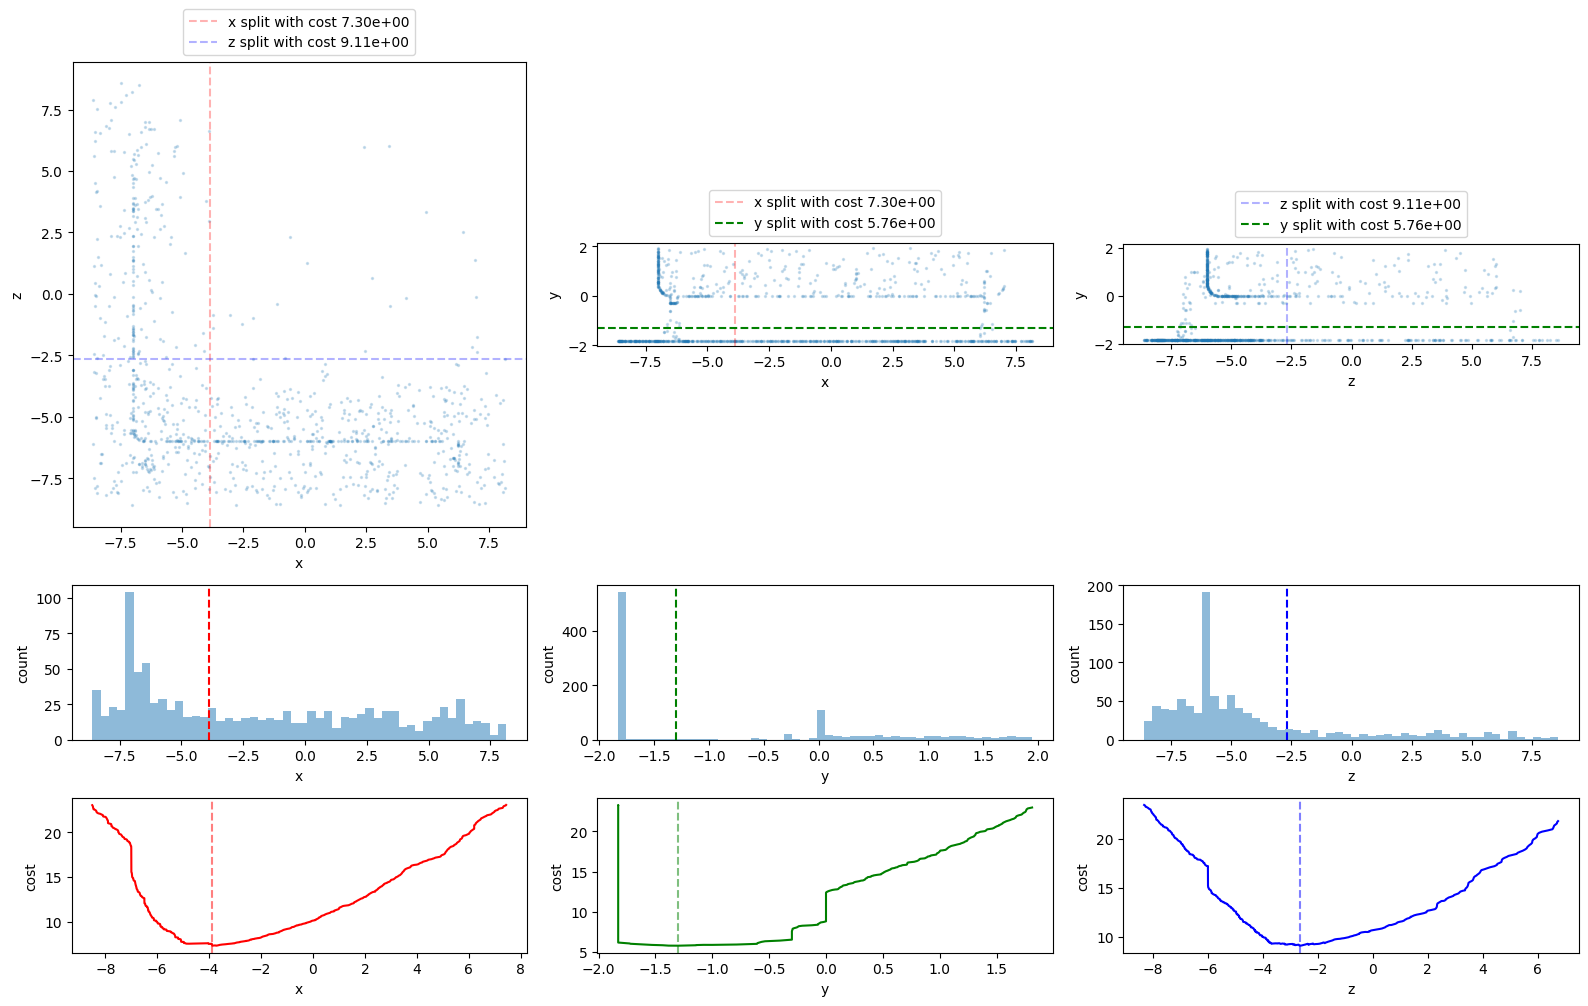

Current focus:
[[-8.64396667  8.14603333]
 [-2.69104407 20.        ]
 [-8.61017197  8.60982803]]
Number of samples in focus: 2874
The min cost is too close to the second min cost, using the dimension with the highest variance instead.
Splits: [-2.9081286   5.51760606 -2.65809331]
Costs: [39.40020939 40.24013036 36.94417057]
Best split dimension: 1


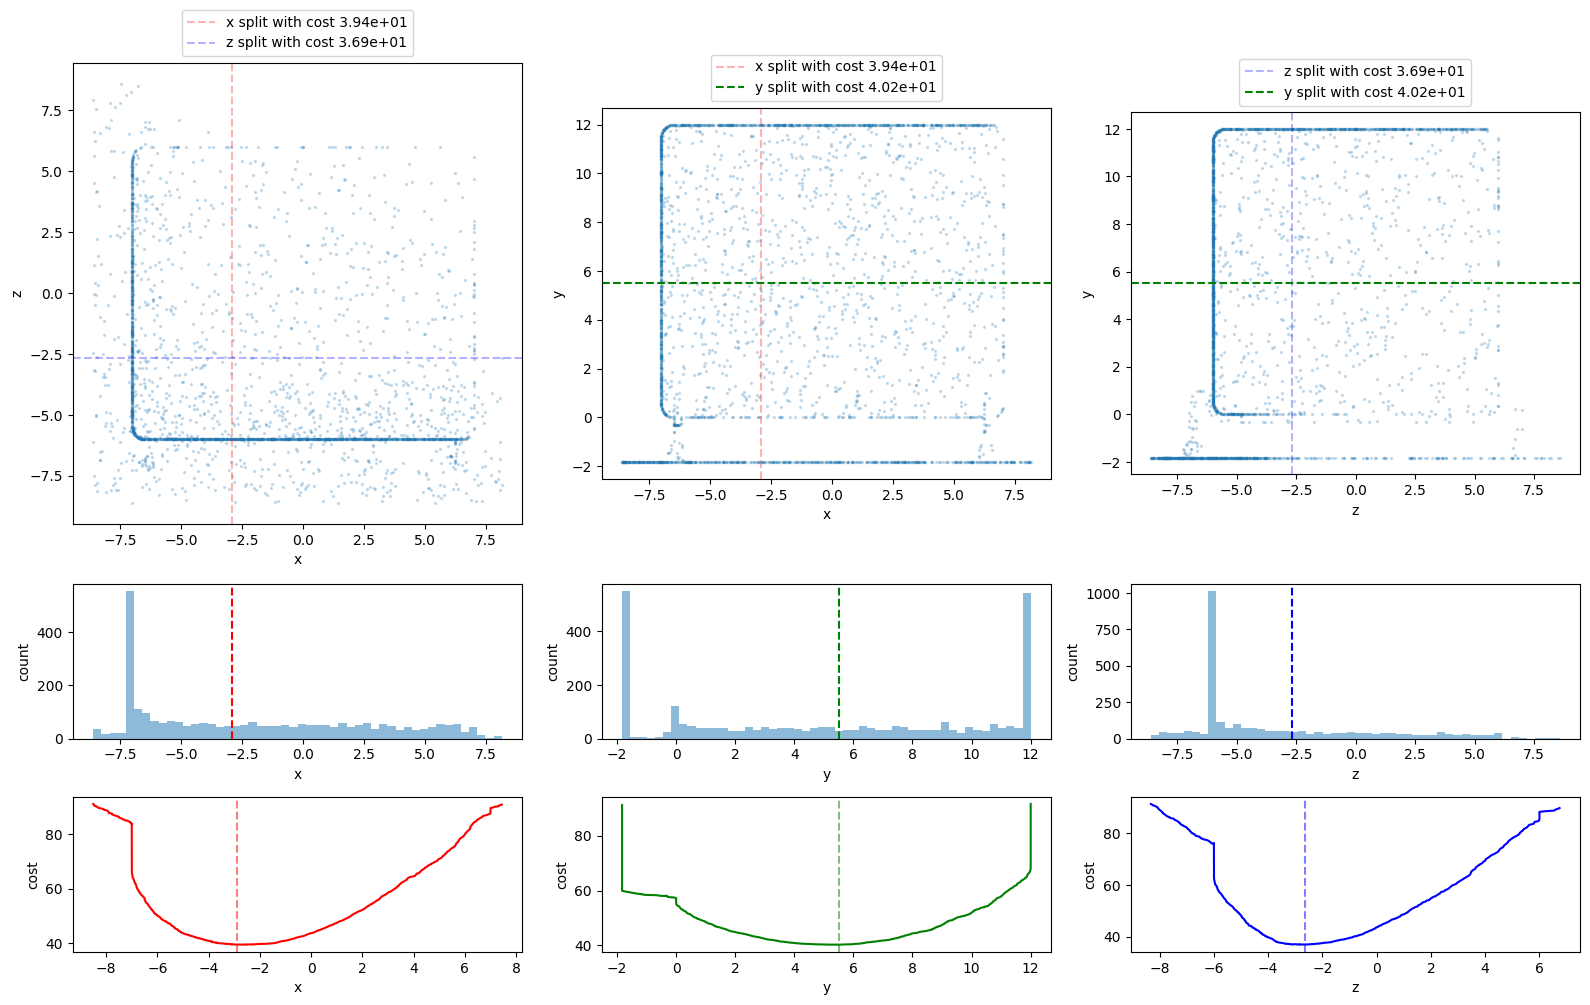

Current focus:
[[-8.60655136  1.43344864]
 [-1.95104527 13.38282585]
 [24.96718155 51.57718155]]
Number of samples in focus: 296
Splits: [-3.51019979 -1.8282136  37.32482333]
Costs: [0.35857627 0.37136529 0.06710123]
Best split dimension: 2


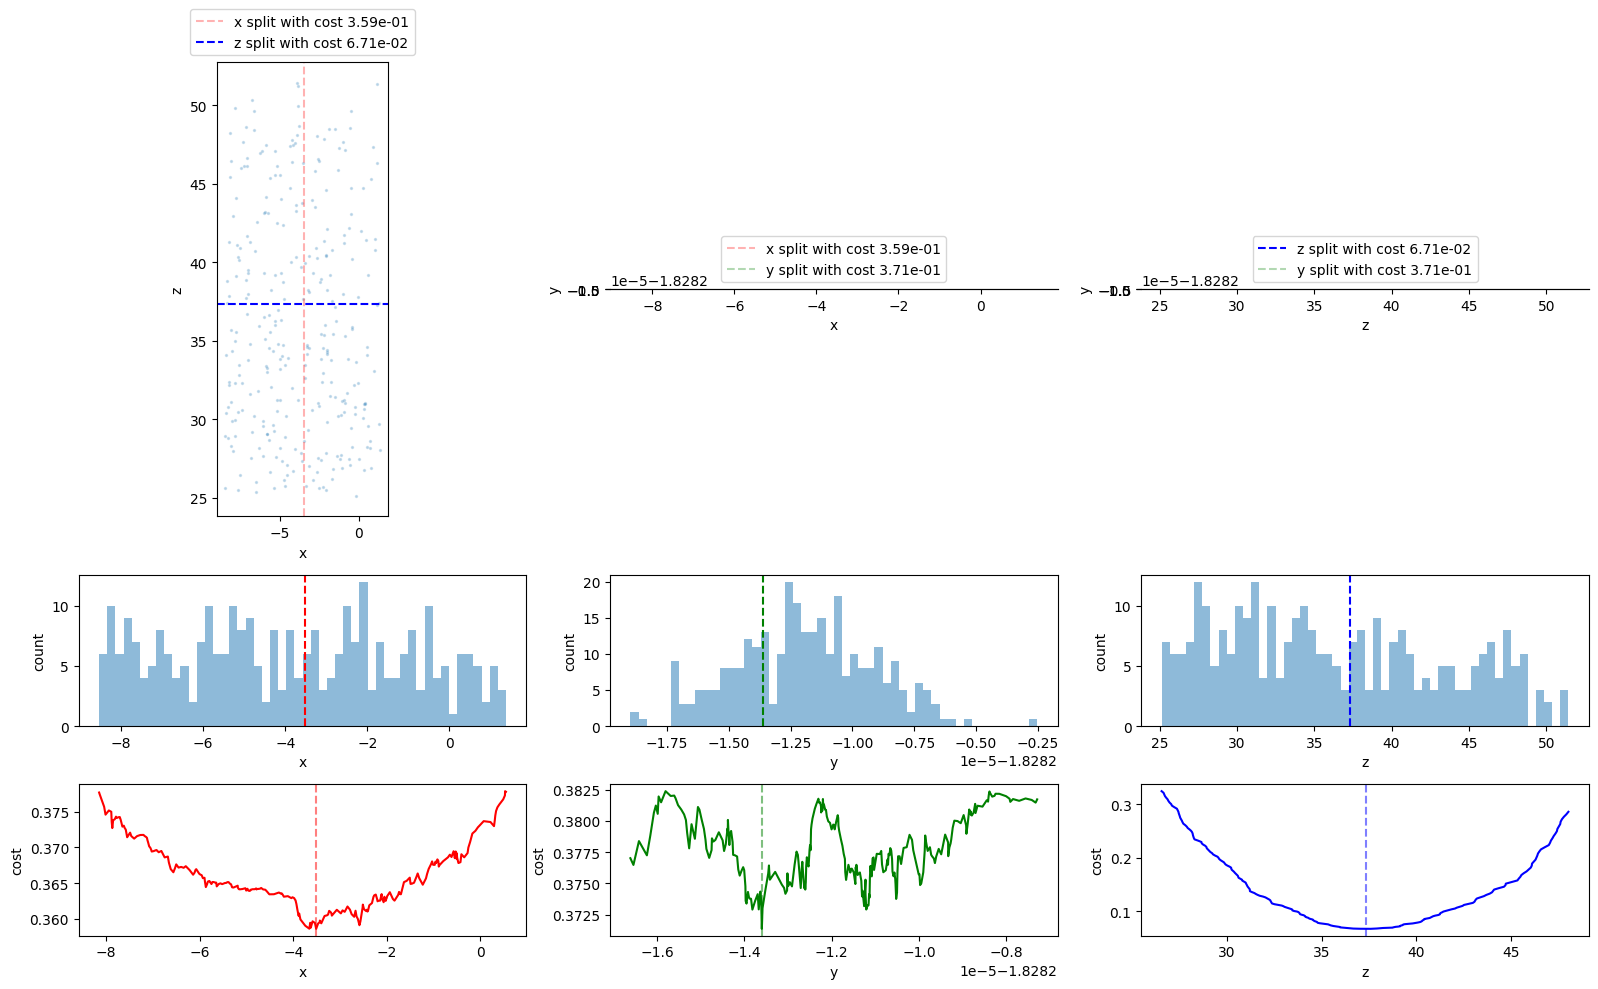

Current focus:
[[-18.73655136   9.84344864]
 [ -1.95104527  13.38282585]
 [-18.39281845  -7.87281845]]
Number of samples in focus: 1663
Splits: [ -3.40933249  -1.82821672 -12.92399903]
Costs: [0.07482848 0.36076567 0.30213063]
Best split dimension: 0


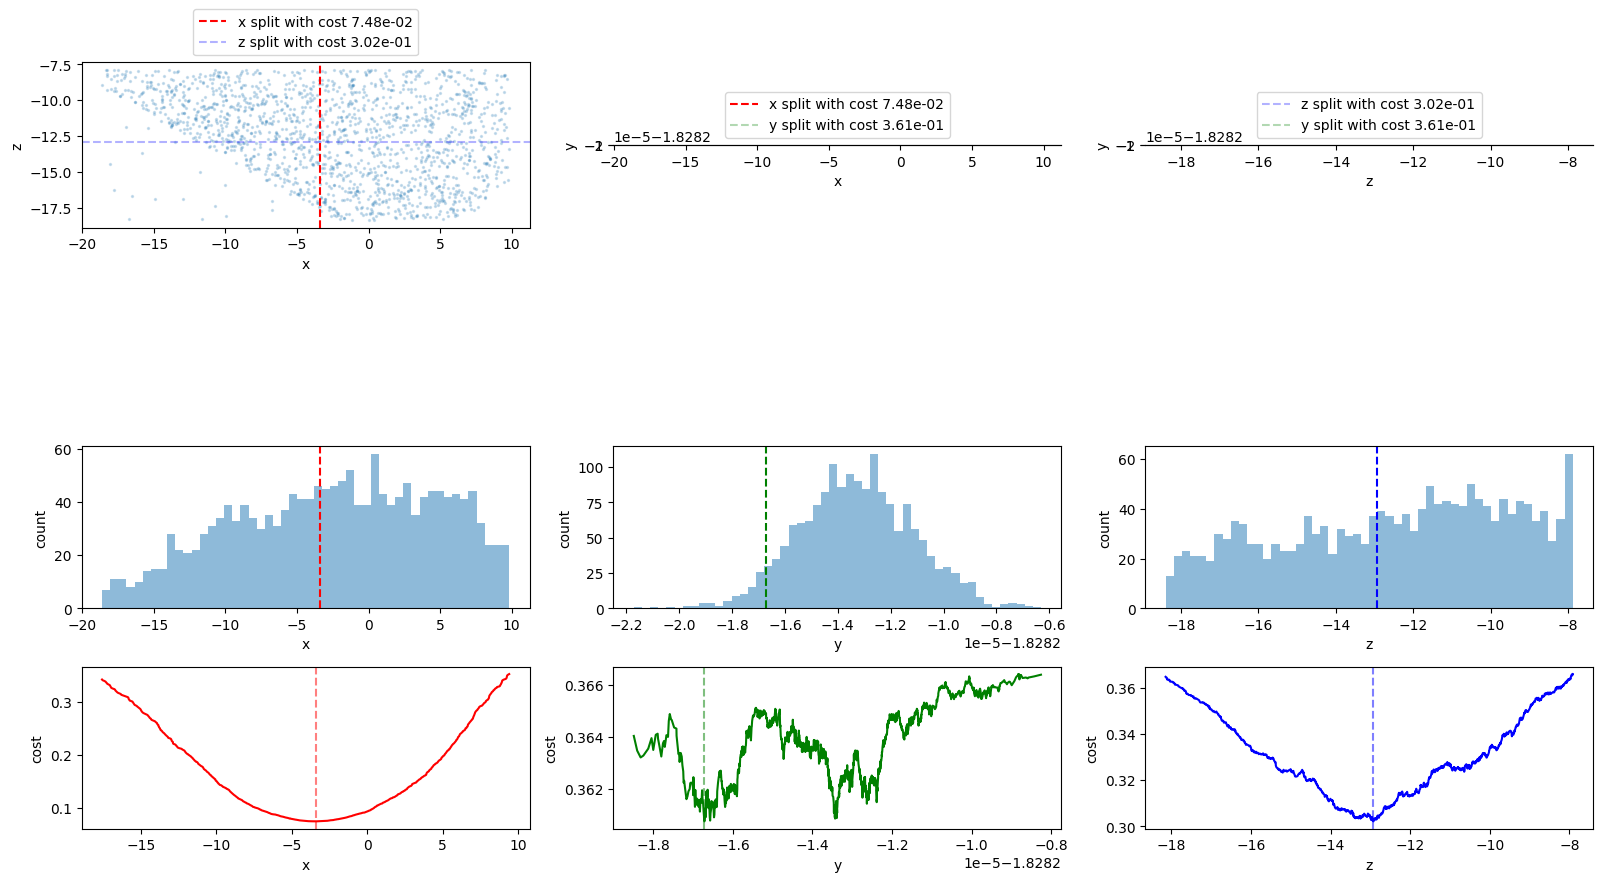

Current focus:
[[-44.78655136  51.76344864]
 [ -1.95104527  13.38282585]
 [-26.24281845  62.04718155]]
Number of samples in focus: 9839
Splits: [ 7.00072186 -1.77844088  6.00017316]
Costs: [554.66901523  28.8474129  243.27279116]
Best split dimension: 1


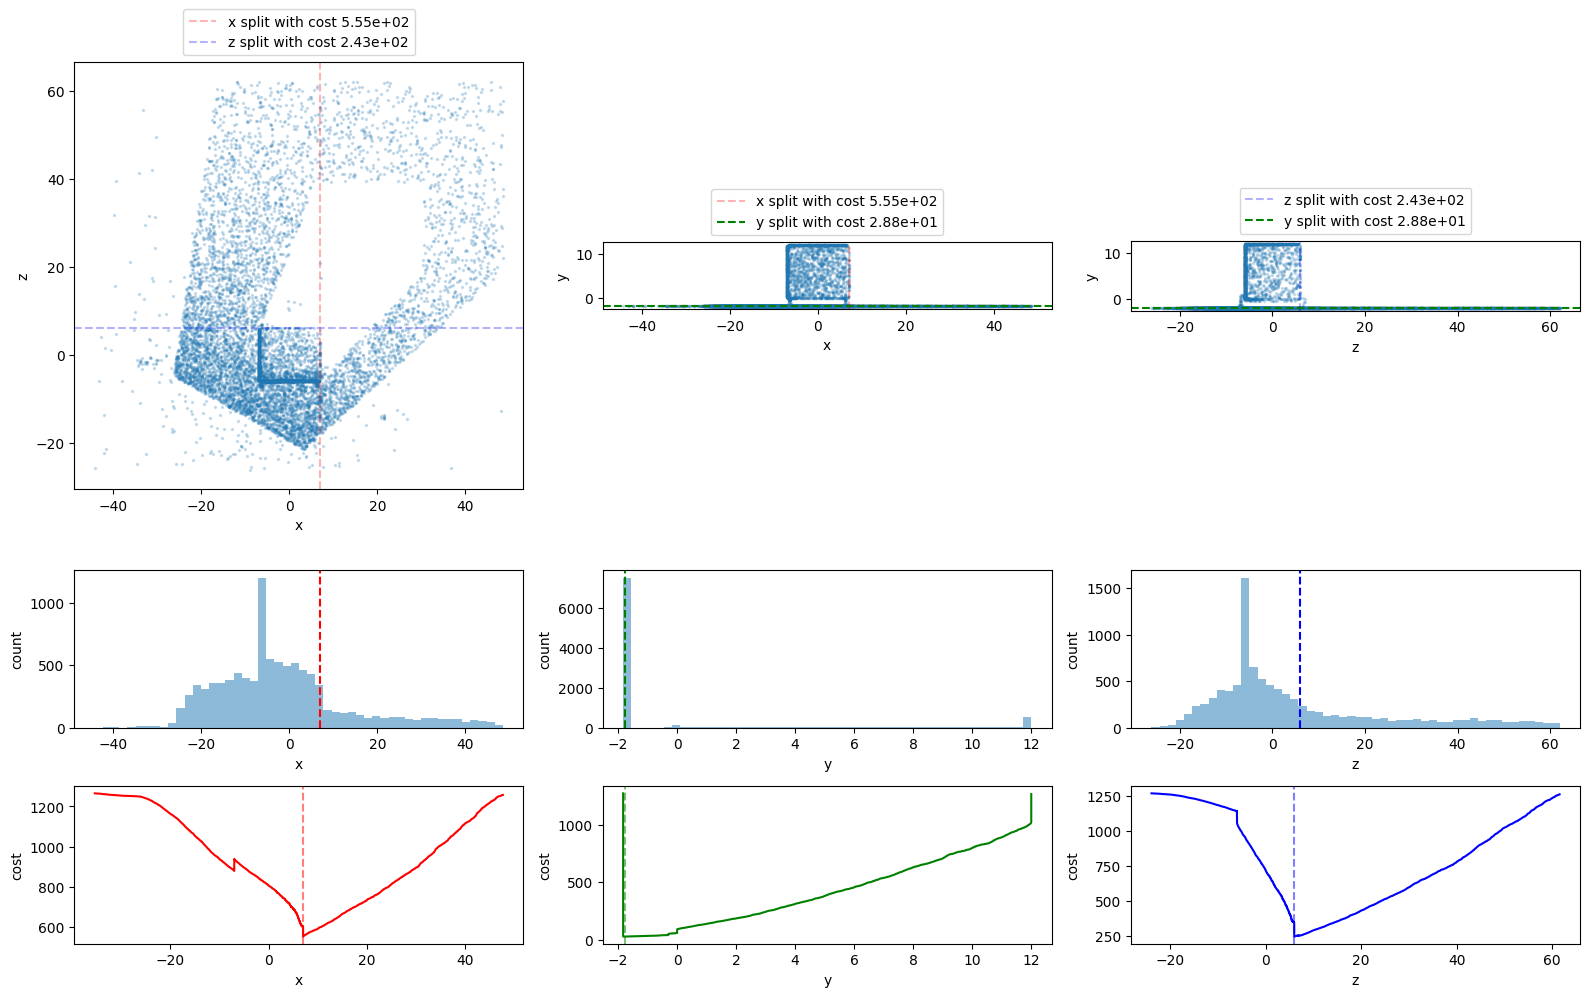

Loaded 951402 samples
Using 10000 samples
Current focus:
[[-20.  50.]
 [ -5.  10.]
 [-50.  50.]]
Number of samples in focus: 7626
Splits: [ 9.0976355  -1.09422678 -0.21024733]
Costs: [537.5343769  376.92130525 600.36208192]
Best split dimension: 1


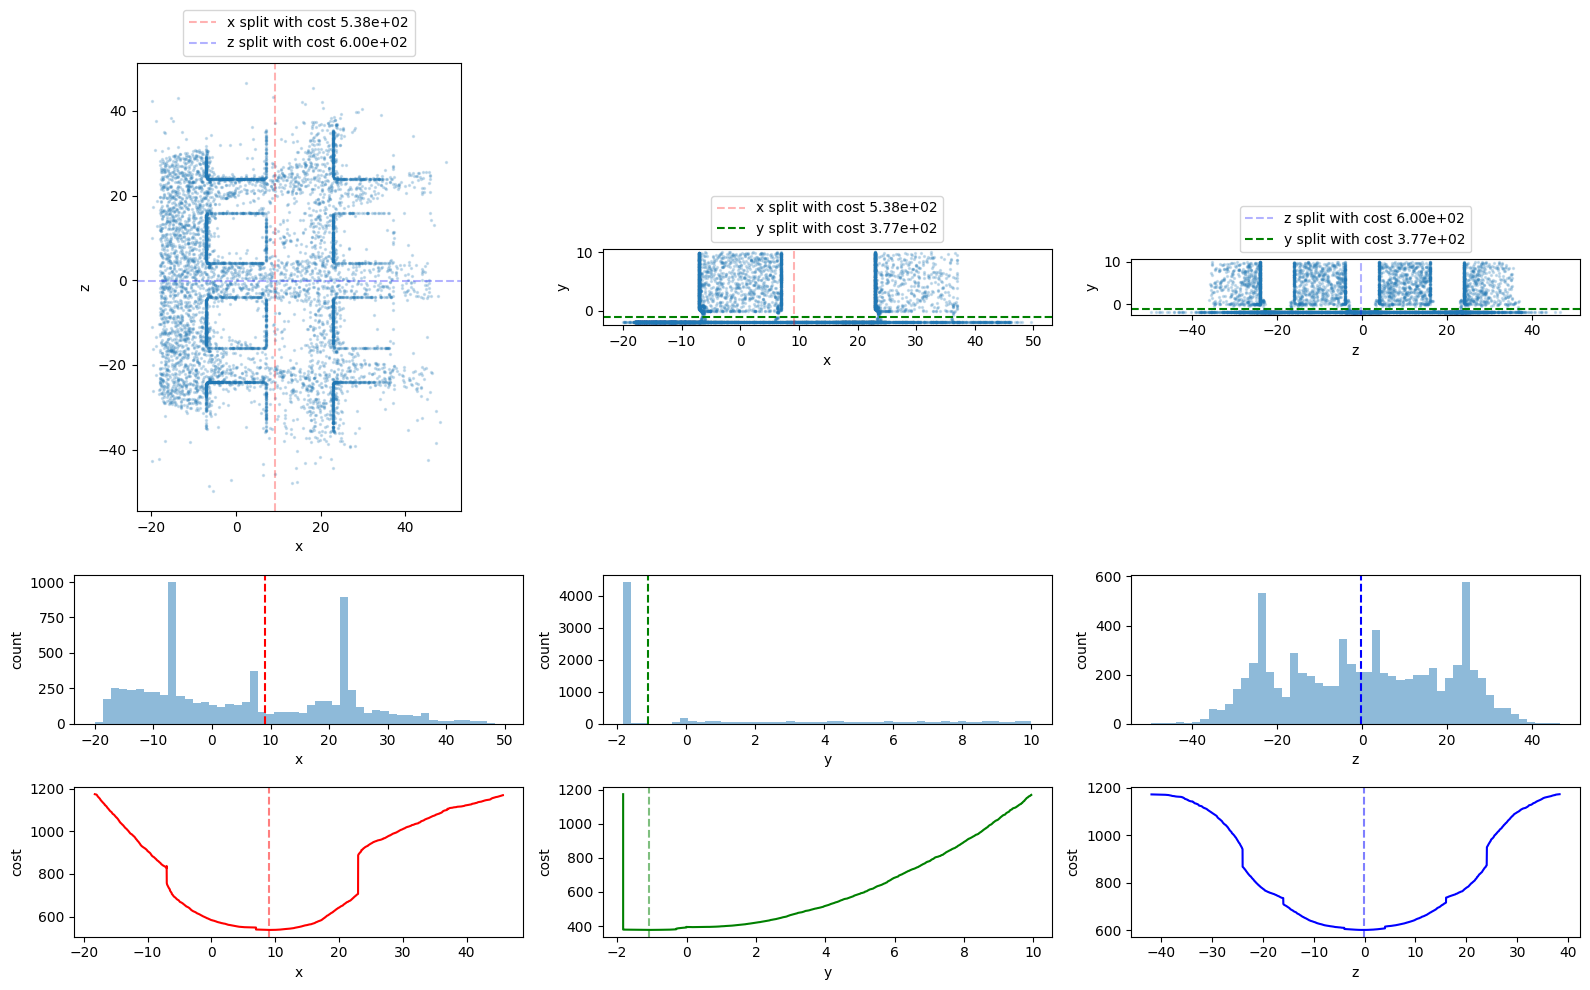

Loaded 612831 samples
Using 10000 samples
Current focus:
[[-3.17484711 -1.69484711]
 [ 0.05999055  1.49999055]
 [ 0.34940857  3.40940857]]
Number of samples in focus: 374
The min cost is too close to the second min cost, using the dimension with the highest variance instead.
Splits: [-2.46253666  0.62451273  1.77505645]
Costs: [0.01625254 0.01487613 0.01391379]
Best split dimension: 2


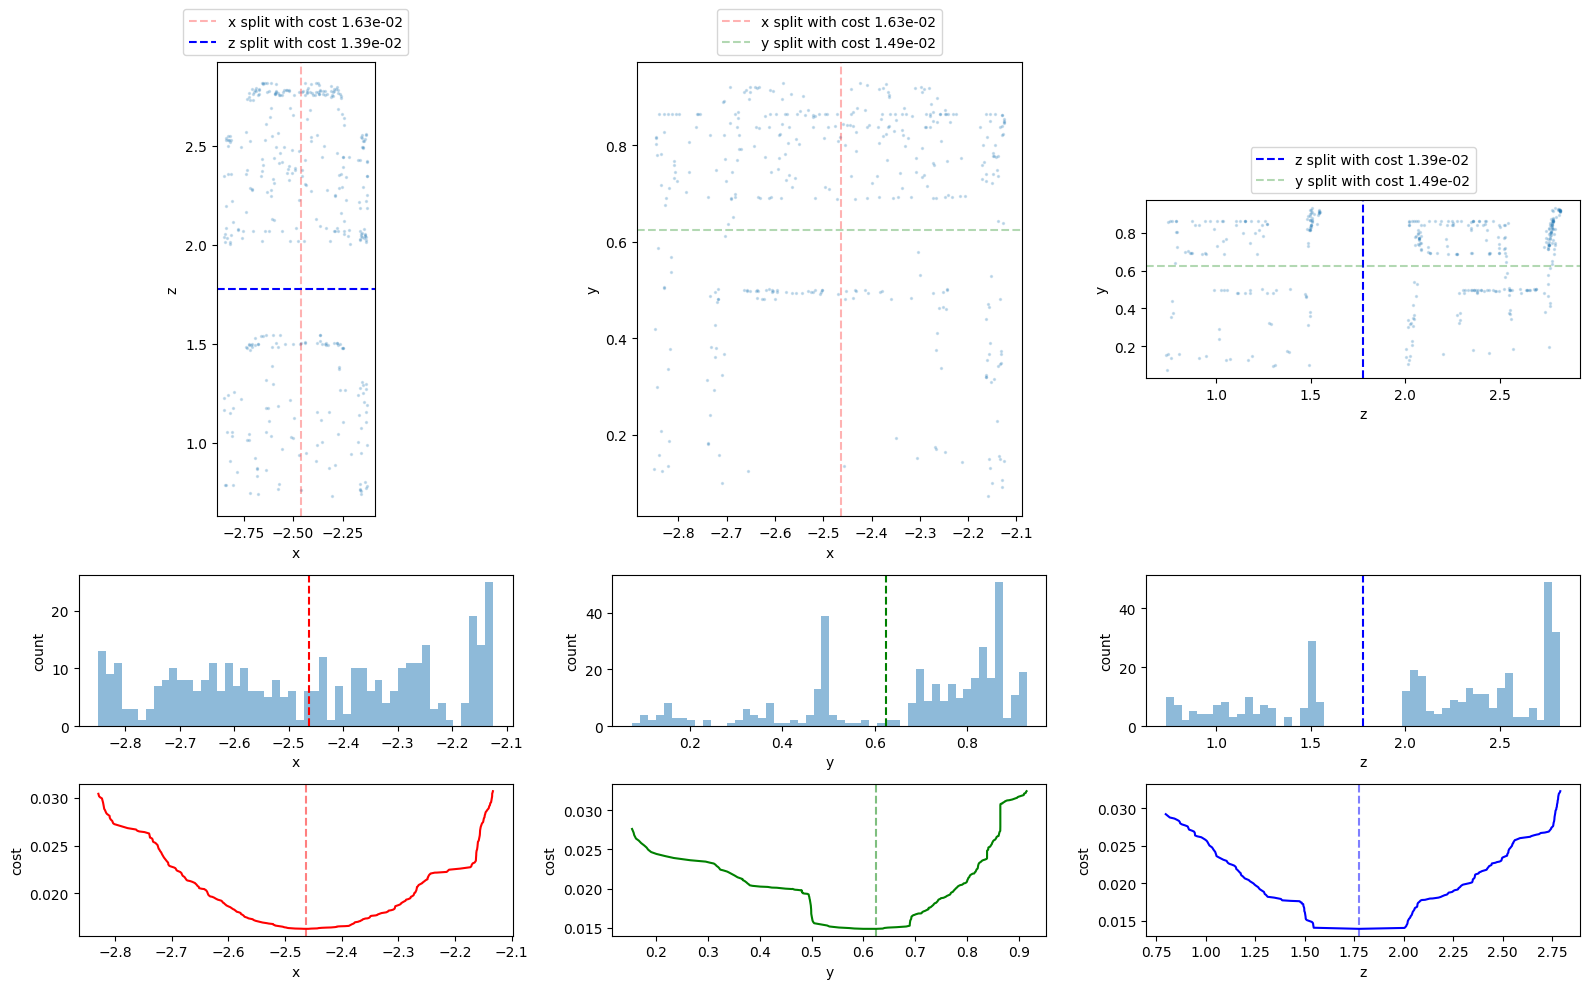

Current focus:
[[-3.17484711 -1.69484711]
 [ 0.05999055  1.49999055]
 [-2.04970241  3.40940857]]
Number of samples in focus: 515
The min cost is too close to the second min cost, using the dimension with the highest variance instead.
Splits: [-2.4589083   0.59954316  0.74237946]
Costs: [0.03764665 0.03423627 0.0365899 ]
Best split dimension: 2


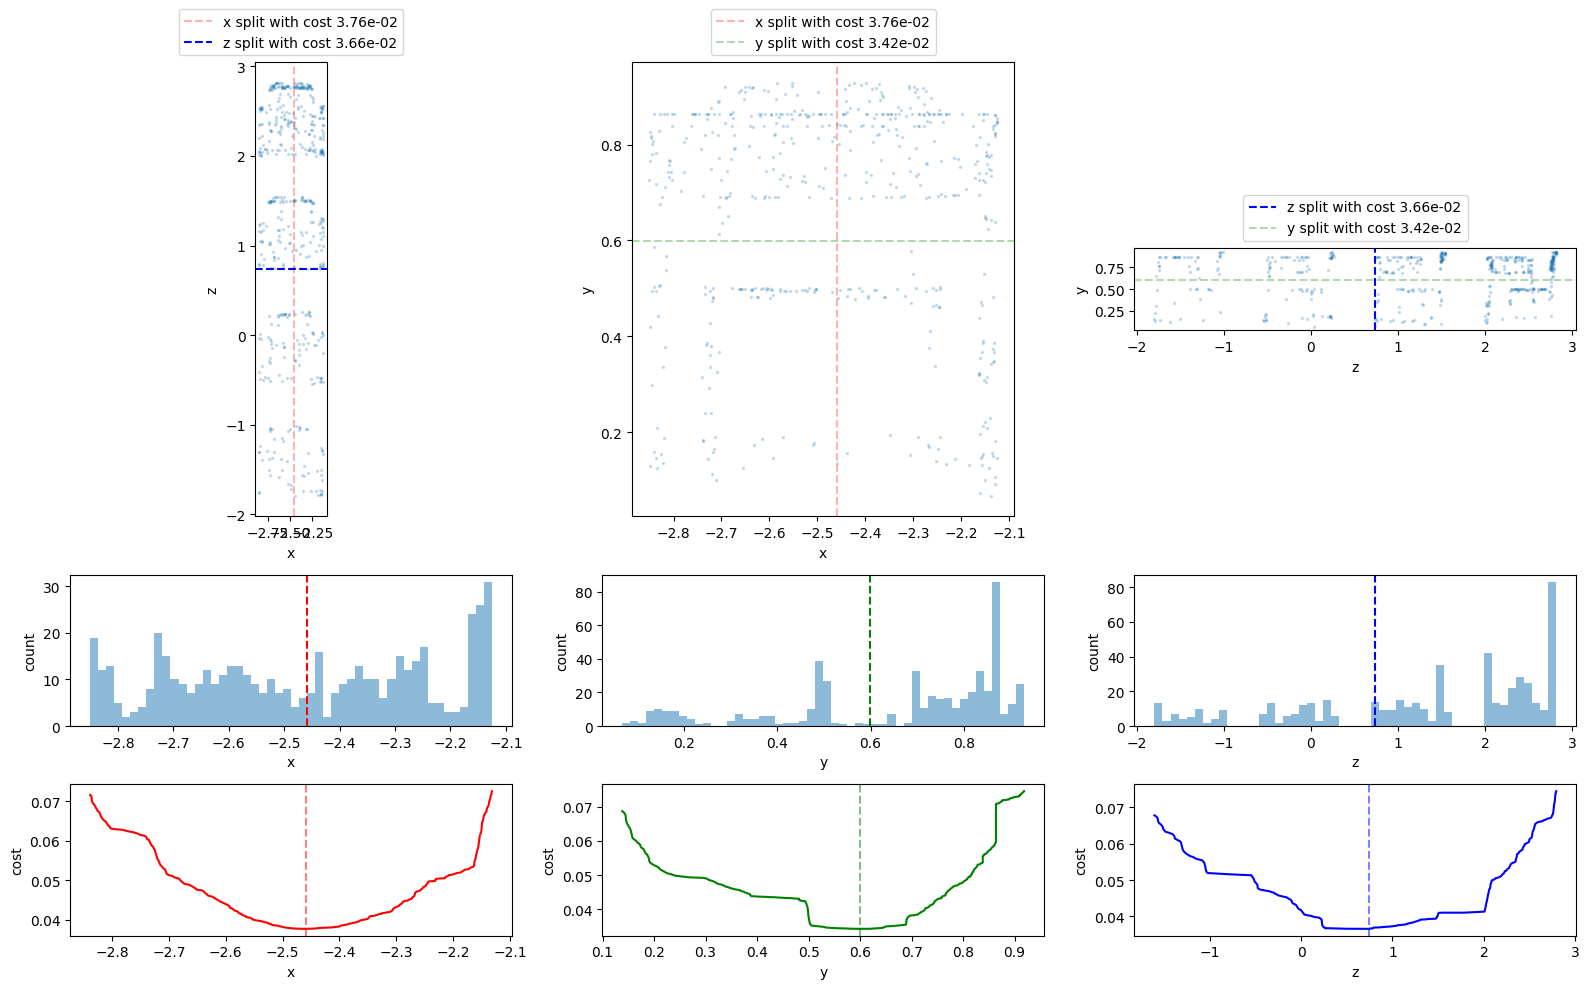

In [11]:
# Batch tests
plt.close('all')
%matplotlib inline

kwargs = {
    "gamma": 1,
    # "lambd": 0,
    "min_samples_per_side": 16,
}
k = 0.2
np.random.seed(41)

# Torus
position, _, _ = load_samples("data/torus-samples-vs3d", 2, 10000)
position[:, 1] *= -1
rois = [
    np.load('output/vs/failure-1-torus-roi.npy', allow_pickle=True),
    np.load('output/vs/failure-5-torus-roi.npy', allow_pickle=True),
    np.load('output/vs/failure-2-torus-roi.npy', allow_pickle=True),
    np.load('output/vs/failure-3-torus-roi.npy', allow_pickle=True),
    np.load('output/vs/success-2-torus-roi.npy', allow_pickle=True),
]
for roi in rois:
    visualize3D(position, roi, k, **kwargs)

position, _, _ = load_samples("data/torus-multi-samples-vs3d", 2, 10000)
position[:, 1] *= -1
roi = np.array([
    [-20, 50],
    [-5, 10],
    [-50, 50],
], dtype=float)
visualize3D(position, roi, k, **kwargs)
    
# Classroom
position, _, _ = load_samples("data/classroom-samples-vs3d", 2, 10000)
rois = [
    # np.load('output/vs/success-3-classroom-roi.npy', allow_pickle=True),
    np.load('output/vs/success-4-classroom-roi.npy', allow_pickle=True),
    np.load('output/vs/failure-4-classroom-roi.npy', allow_pickle=True),
]
for roi in rois:
    visualize3D(position, roi, k, **kwargs)

In [154]:
position, _, _ = load_samples("data/torus-samples-vs3d", 2, 10000)
position[:, 1] *= -1
roi = np.load('output/vs/failure-3-torus-roi.npy', allow_pickle=True)
print(roi)
mask = (position[:, 0] >= roi[0, 0]) & (position[:, 0] <= roi[0, 1]) & (position[:, 1] >= roi[1, 0]) & (position[:, 1] <= roi[1, 1]) & (position[:, 2] >= roi[2, 0]) & (position[:, 2] <= roi[2, 1])
X = position[mask][:, [0, 2]]
variance_scan_all(X, **kwargs)


Loaded 687278 samples
Using 10000 samples
[[-18.73655136   9.84344864]
 [ -1.95104527  13.38282585]
 [-18.39281845  -7.87281845]]


(array([ -1.95867431, -12.10894585]), array([9.73436129, 9.45875887]))

In [120]:
np.linalg.det(np.delete(np.delete(np.cov(X, rowvar=False, ddof=0), 1, 1), 1, 0)), np.linalg.det(np.maximum(np.cov(X, rowvar=False, ddof=0), 1e-3))

(453.3593866467257, 0.45329856871272806)

In [26]:
# X = position[:100]
X = np.array([[1, 0], [1, 0], [1, 2]])
X.shape, np.cov(X, rowvar=False, ddof=1)

((3, 2),
 array([[0.        , 0.        ],
        [0.        , 1.33333333]]))